In [2]:
import gym
from gym import spaces
import numpy as np

class WarehouseOrientationEnv(gym.Env):
    """
    Magazyn NxN z orientacją robota:
      - Stan: [robot_x, robot_y, target_x, target_y, orientation_index]
      - Akcje: 0=obrót w lewo o alpha, 1=obrót w prawo o alpha, 2=ruch do przodu
    """
    def __init__(self, n=5, alpha=90, max_steps=100):
        super().__init__()  # Wywołanie init z gym.Env

        self.n = n
        self.alpha = alpha
        self.max_steps = max_steps
        
        # Ilu "kroków" orientacji (np. 360 / 90 = 4)
        assert 360 % alpha == 0, "Kąt alpha musi dzielić 360 (np. 90, 45, 60)."
        self.num_orientations = 360 // alpha

        # Przestrzeń akcji: 3 akcje
        self.action_space = spaces.Discrete(3)

        # Przestrzeń stanów (Box z 5 wymiarami):
        #   robot_x, robot_y, target_x, target_y, orientation_index
        low = np.array([0, 0, 0, 0, 0], dtype=np.float32)
        high = np.array([n-1, n-1, n-1, n-1, self.num_orientations - 1], dtype=np.float32)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        # Pola do przechowywania stanu
        self.robot_x = 0
        self.robot_y = 0
        self.target_x = 0
        self.target_y = 0
        self.orientation = 0  # indeks 0..(num_orientations-1)
        self.current_step = 0

        # Dodatkowe flagi
        self.terminated = False
        self.reward = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # możliwe wywołanie, jeśli Gym >=0.26
        self.current_step = 0
        self.terminated = False
        self.reward = 0

        # Losujemy pozycję robota
        self.robot_x = np.random.randint(self.n)
        self.robot_y = np.random.randint(self.n)

        # Losujemy pozycję celu (inną niż robota)
        while True:
            self.target_x = np.random.randint(self.n)
            self.target_y = np.random.randint(self.n)
            if (self.target_x != self.robot_x) or (self.target_y != self.robot_y):
                break

        # Losujemy orientację
        self.orientation = np.random.randint(self.num_orientations)

        return self._get_obs()

    def step(self, action):
        """
        Zwraca krotkę (observation, reward, terminated, truncated, info).
        W Gym <=0.25 może to być (observation, reward, done, info).
        """
        self.reward = 0
        old_distance = np.linalg.norm([self.robot_x - self.target_x,
                                       self.robot_y - self.target_y])

        # Wykonanie akcji
        if action == 0:
            # Obrót w lewo o alpha
            self.orientation = (self.orientation - 1) % self.num_orientations
        elif action == 1:
            # Obrót w prawo o alpha
            self.orientation = (self.orientation + 1) % self.num_orientations
        elif action == 2:
            # Ruch do przodu w kierunku aktualnej orientacji
            self._move_forward()
        else:
            raise ValueError(f"Nieznana akcja: {action}")

        # Niewielka kara za każdy ruch (np. -0.0001)
        self.reward += -0.0001

        new_distance = np.linalg.norm([self.robot_x - self.target_x,
                                       self.robot_y - self.target_y])

        # Drobna nagroda za zbliżenie się do celu:
        if new_distance < old_distance:
            self.reward += 0.1
        elif new_distance > old_distance:
            # Kara za oddalenie się od celu
            self.reward -= 0.1

        # Sprawdzamy, czy dotarliśmy do celu
        if (self.robot_x == self.target_x) and (self.robot_y == self.target_y):
            self.reward = 1.0
            self.terminated = True

        # Inkrementacja kroku
        self.current_step += 1
        truncated = (self.current_step >= self.max_steps)

        return self._get_obs(), self.reward, self.terminated, truncated, {}

    def render(self, mode='human'):
        """
        Prosta wizualizacja w konsoli.
        'R' = robot, 'T' = cel, '.' = puste pole
        """
        grid = [["." for _ in range(self.n)] for _ in range(self.n)]

        # Robot
        grid[self.robot_y][self.robot_x] = "R"
        # Cel
        grid[self.target_y][self.target_x] = "T"

        print("=" * (2*self.n))
        for row in grid:
            print(" ".join(row))
        print("=" * (2*self.n))
        orientation_deg = self.orientation * self.alpha
        print(f"Orientacja: index={self.orientation}, kąt={orientation_deg}°")

    def _get_obs(self):
        """
        Zwraca obserwację:
           [robot_x, robot_y, target_x, target_y, orientation_index]
        """
        return np.array([
            self.robot_x,
            self.robot_y,
            self.target_x,
            self.target_y,
            self.orientation
        ], dtype=np.float32)

    def _move_forward(self):
        """
        Ruch robota do przodu o 1 kratkę w zależności od orientation.
        Jeśli ruch poza planszę -> kara i zakończenie epizodu.
        """
        angle_deg = self.orientation * self.alpha
        angle_rad = np.deg2rad(angle_deg)

        dx = int(round(np.cos(angle_rad)))
        dy = int(round(np.sin(angle_rad)))

        new_x = self.robot_x + dx
        new_y = self.robot_y + dy

        # Sprawdzenie granic
        if 0 <= new_x < self.n and 0 <= new_y < self.n:
            self.robot_x = new_x
            self.robot_y = new_y
        else:
            # Kara za wyjście poza obszar i zakończenie
            self.reward -= 0.5
            self.terminated = True

In [3]:
import gym
from gym import spaces
import numpy as np

class WarehouseGridEnv2(gym.Env):
    """
    Magazyn NxN z klasycznym sterowaniem (4 akcje):
      - Stan: [robot_x, robot_y, target_x, target_y, dist_up, dist_down, dist_left, dist_right, dist_diag]
      - Akcje: 0=góra, 1=dół, 2=lewo, 3=prawo

    Dodatkowo:
      - `grid` opisuje siatkę (n x n), w której 0 to wolne pole, 1 – pole zajęte.
      - Wejście na pole o wartości 1 traktujemy jak kolizję.
    """
    def __init__(self, 
                 grid=None,
                 n=5, 
                 max_steps=100):
        super().__init__()

        self.max_steps = max_steps
        
        # Jeżeli przekazano siatkę, to z niej wyznacz rozmiar, w przeciwnym razie stwórz wolny obszar NxN
        if grid is not None:
            self.grid = grid
            self.n = self.grid.shape[0]
        else:
            self.n = n
            # Domyślnie tworzymy wolną siatkę, same zera
            self.grid = np.zeros((self.n, self.n), dtype=int)

        # Przestrzeń akcji: 4
        self.action_space = spaces.Discrete(4)

        # Observation space: 9 wymiarów (4 współrzędne + 5 sensorów)
        low = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0,0,0,0], dtype=np.float32)
        high = np.array([
            self.n - 1,  # robot_x
            self.n - 1,  # robot_y
            self.n - 1,  # target_x
            self.n - 1,  # target_y
            self.n - 1,  # dist_up
            self.n - 1,  # dist_down
            self.n - 1,  # dist_left
            self.n - 1,  # dist_right
            self.n - 1,  # dist_diag
        ], dtype=np.float32)
        self.observation_space = 12

        # Zmienna do śledzenia stanu (inicjalizowana w reset)
        self.robot_x = 0
        self.robot_y = 0
        self.target_x = 0
        self.target_y = 0
        self.current_step = 0
        self.terminated = False
        self.reward = 0

    def _distance_to_wall(self, start_x, start_y, dx, dy):
        """
        Zwraca liczbę wolnych pól w kierunku (dx, dy) do najbliższej ściany (przeszkody) 
        lub krawędzi siatki, startując od (start_x, start_y).
        """
        step_count = 0
        x, y = start_x, start_y
        while True:
            x_next = x + dx
            y_next = y + dy
            # Sprawdzamy krawędź
            if not (0 <= x_next < self.n and 0 <= y_next < self.n):
                return step_count
            # Sprawdzamy przeszkodę
            if self.grid[y_next, x_next] == 1:
                return step_count
            step_count += 1
            x, y = x_next, y_next

    def _get_sensors(self):
        rx, ry = self.robot_x, self.robot_y
        dist_up    = self._distance_to_wall(rx, ry,  0, -1)
        dist_down  = self._distance_to_wall(rx, ry,  0,  1)
        dist_left  = self._distance_to_wall(rx, ry, -1,  0)
        dist_right = self._distance_to_wall(rx, ry,  1,  0)
        dist_diag1  = self._distance_to_wall(rx, ry, -1, -1)
        dist_diag2  = self._distance_to_wall(rx, ry, -1, 1)
        dist_diag3  = self._distance_to_wall(rx, ry, 1, -1)
        dist_diag4  = self._distance_to_wall(rx, ry, 1, 1)  # przykład: ukos w górę-lewo
        return np.array([dist_up, dist_down, dist_left, dist_right, dist_diag1,dist_diag2,dist_diag3,dist_diag4], dtype=np.float32)

    def _get_obs(self):
        # Podstawowe obserwacje (4 wartości)
        podstawowe = np.array([self.robot_x, self.robot_y, 
                               self.target_x, self.target_y], dtype=np.float32)
        # Sensory (5 wartości)
        sensory = self._get_sensors()
        # Łączymy w jeden wektor stanu
        return np.concatenate([podstawowe, sensory])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.terminated = False
        self.reward = 0

        # Losowanie pozycji robota (tylko na wolnym polu)
        while True:
            rx = np.random.randint(self.n)
            ry = np.random.randint(self.n)
            if self.grid[ry, rx] == 0:  # wolne pole
                self.robot_x = rx
                self.robot_y = ry
                break

        # Losowanie pozycji celu (tylko na wolnym polu i różne od pozycji robota)
        while True:
            tx = np.random.randint(self.n)
            ty = np.random.randint(self.n)
            if (self.grid[ty, tx] == 0 and
                (tx != self.robot_x or ty != self.robot_y)):
                self.target_x = tx
                self.target_y = ty
                break

        return self._get_obs()

    def step(self, action):
        old_distance = np.linalg.norm([self.robot_x - self.target_x,
                                       self.robot_y - self.target_y])

        # Potencjalna nowa pozycja
        if action == 0:   # góra
            new_x = self.robot_x
            new_y = self.robot_y - 1
        elif action == 1: # dół
            new_x = self.robot_x
            new_y = self.robot_y + 1
        elif action == 2: # lewo
            new_x = self.robot_x - 1
            new_y = self.robot_y
        elif action == 3: # prawo
            new_x = self.robot_x + 1
            new_y = self.robot_y
        else:
            raise ValueError(f"Nieznana akcja: {action}")

        # Sprawdzenie warunków kolizji lub wyjścia poza obszar
        if not (0 <= new_x < self.n and 0 <= new_y < self.n):
            # Kara za wyjście poza obszar
            self.reward = -0.5
            self.terminated = True
        elif self.grid[new_y, new_x] == 1:
            # Kara za kolizję z polem zajętym
            self.reward = -0.5
            self.terminated = True
        else:
            # Jeżeli pole jest wolne, aktualizujemy pozycję
            self.robot_x = new_x
            self.robot_y = new_y
            # Domyślna, niewielka kara za ruch
            self.reward = -0.0001

            new_distance = np.linalg.norm([self.robot_x - self.target_x,
                                           self.robot_y - self.target_y])
            # Nagroda/kara za przybliżenie/oddalenie się od celu
            if new_distance < old_distance:
                self.reward += 0.1
            elif new_distance > old_distance:
                self.reward -= 0.1

        # Sprawdzamy, czy dotarliśmy do celu
        if (self.robot_x == self.target_x) and (self.robot_y == self.target_y):
            self.reward = 1.0
            self.terminated = True

        self.current_step += 1
        truncated = (self.current_step >= self.max_steps)

        return self._get_obs(), self.reward, self.terminated, truncated, {}

    def render(self, mode='human'):
        """
        Tekstowa wizualizacja środowiska:
        'R' = robot, 'T' = cel, 'X' = przeszkoda, '.' = puste pole.
        """
        grid_render = []
        for y in range(self.n):
            row_symbols = []
            for x in range(self.n):
                if self.grid[y, x] == 1:
                    symbol = "X"
                else:
                    symbol = "."
                
                if x == self.robot_x and y == self.robot_y:
                    symbol = "R"
                if x == self.target_x and y == self.target_y:
                    symbol = "T"
                row_symbols.append(symbol)
            grid_render.append(row_symbols)

        print("=" * (2 * self.n))
        for row in grid_render:
            print(" ".join(row))
        print("=" * (2 * self.n))


In [4]:
import gym
from gym import spaces
import numpy as np

class WarehouseGridEnv(gym.Env):
    """
    Magazyn NxN z klasycznym sterowaniem (4 akcje):
      - Stan: [robot_x, robot_y, target_x, target_y]
      - Akcje: 0=góra, 1=dół, 2=lewo, 3=prawo
    """
    def __init__(self, n=5, max_steps=100):
        super().__init__()  # wywołanie __init__ z gym.Env

        self.n = n
        self.max_steps = max_steps

        # Przestrzeń akcji: 4
        self.action_space = spaces.Discrete(4)

        # Stan: (robot_x, robot_y, target_x, target_y)
        low = np.array([0, 0, 0, 0], dtype=np.float32)
        high = np.array([n-1, n-1, n-1, n-1], dtype=np.float32)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        self.robot_x = 0
        self.robot_y = 0
        self.target_x = 0
        self.target_y = 0
        self.current_step = 0
        self.terminated = False
        self.reward = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.terminated = False
        self.reward = 0

        # Losowanie pozycji robota
        self.robot_x = np.random.randint(self.n)
        self.robot_y = np.random.randint(self.n)

        # Losowanie pozycji celu
        while True:
            self.target_x = np.random.randint(self.n)
            self.target_y = np.random.randint(self.n)
            if (self.target_x != self.robot_x) or (self.target_y != self.robot_y):
                break

        return self._get_obs()

    def step(self, action):
        old_distance = np.linalg.norm([self.robot_x - self.target_x,
                                       self.robot_y - self.target_y])

        if action == 0:   # góra
            new_x = self.robot_x
            new_y = self.robot_y - 1
        elif action == 1: # dół
            new_x = self.robot_x
            new_y = self.robot_y + 1
        elif action == 2: # lewo
            new_x = self.robot_x - 1
            new_y = self.robot_y
        elif action == 3: # prawo
            new_x = self.robot_x + 1
            new_y = self.robot_y
        else:
            raise ValueError(f"Nieznana akcja: {action}")

        # Sprawdzenie granic
        if not (0 <= new_x < self.n and 0 <= new_y < self.n):
            # Kara za wyjście poza obszar
            self.reward = -0.5
            self.terminated = True
        else:
            # Aktualizacja pozycji
            self.robot_x = new_x
            self.robot_y = new_y
            # Domyślna niewielka kara za ruch
            self.reward = -0.0001

            new_distance = np.linalg.norm([self.robot_x - self.target_x,
                                           self.robot_y - self.target_y])
            # Nagroda/kara za przybliżenie/oddalenie
            if new_distance < old_distance:
                self.reward += 0.1
            elif new_distance > old_distance:
                self.reward -= 0.1

        # Sprawdzamy, czy dotarliśmy do celu
        if (self.robot_x == self.target_x) and (self.robot_y == self.target_y):
            self.reward = 1.0
            self.terminated = True

        self.current_step += 1
        truncated = (self.current_step >= self.max_steps)

        return self._get_obs(), self.reward, self.terminated, truncated, {}

    def render(self, mode='human'):
        """
        Tekstowa wizualizacja środowiska:
        'R' = robot, 'T' = cel, '.' = puste pole.
        """
        grid = [["." for _ in range(self.n)] for _ in range(self.n)]
        grid[self.robot_y][self.robot_x] = "R"
        grid[self.target_y][self.target_x] = "T"

        print("=" * (2 * self.n))
        for row in grid:
            print(" ".join(row))
        print("=" * (2 * self.n))

    def _get_obs(self):
        return np.array([self.robot_x, self.robot_y,
                         self.target_x, self.target_y], dtype=np.float32)


In [5]:
import gym
from gym import spaces
import numpy as np

class WarehouseGridEnv(gym.Env):
    """
    Magazyn NxN z klasycznym sterowaniem:
      - Stan: [r_x, r_y, t_x, t_y]
      - Akcje:
        0 = góra (y -= 1)
        1 = dół (y += 1)
        2 = lewo (x -= 1)
        3 = prawo (x += 1)
    """

    def __init__(self, n=5, max_steps=100):
        super(WarehouseGridEnv, self).__init__()
        
        self.n = n
        self.max_steps = max_steps

        # Przestrzeń akcji: 4 akcje
        #  0: góra
        #  1: dół
        #  2: lewo
        #  3: prawo
        self.action_space = spaces.Discrete(4)

        # Przestrzeń stanów (r_x, r_y, t_x, t_y) - wszystko w [0, n-1]
        low = np.array([0, 0, 0, 0], dtype=np.float32)
        high = np.array([n-1, n-1, n-1, n-1], dtype=np.float32)
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

        # Pola do przechowywania stanu
        self.robot_x = 0
        self.robot_y = 0
        self.target_x = 0
        self.target_y = 0
        
        self.current_step = 0
        self.reward = 0
        self.terminated = False

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        self.current_step = 0
        self.terminated = False
        
        # Losujemy pozycję robota
        self.robot_x = np.random.randint(self.n)
        self.robot_y = np.random.randint(self.n)
        self.reward = 0
        
        # Losujemy pozycję celu (inną niż robota)
        while True:
            self.target_x = np.random.randint(self.n)
            self.target_y = np.random.randint(self.n)
            if (self.target_x != self.robot_x) or (self.target_y != self.robot_y):
                break

        return self._get_obs()

    def step(self, action):
        self.reward = 0

        # Odległość przed akcją
        old_distance = np.linalg.norm([
            self.robot_x - self.target_x,
            self.robot_y - self.target_y
        ])

        # Wykonujemy ruch w zależności od akcji
        if action == 0:   # góra
            new_x = self.robot_x
            new_y = self.robot_y - 1
        elif action == 1: # dół
            new_x = self.robot_x
            new_y = self.robot_y + 1
        elif action == 2: # lewo
            new_x = self.robot_x - 1
            new_y = self.robot_y
        elif action == 3: # prawo
            new_x = self.robot_x + 1
            new_y = self.robot_y
        else:
            raise ValueError(f"Nieznana akcja: {action}")

        # Sprawdzamy, czy wychodzimy poza magazyn
        if not (0 <= new_x < self.n and 0 <= new_y < self.n):
            # Kara za wyjście poza obszar + zakończenie epizodu
            self.reward = -0.5
            self.terminated = True
        else:
            # Aktualizujemy pozycję
            self.robot_x = new_x
            self.robot_y = new_y

        # Domyślna niewielka kara (koszt) za ruch
        self.reward += -0.0001

        # Nowa odległość
        new_distance = np.linalg.norm([
            self.robot_x - self.target_x,
            self.robot_y - self.target_y
        ])

        # Nagroda/kara w zależności od tego, czy zbliżyliśmy się do celu
        if not self.terminated:  # Tylko jeśli jeszcze nie zakończono
            if new_distance < old_distance:
                self.reward += 0.1   # przybliżenie
            elif new_distance > old_distance:
                self.reward -= 0.1   # oddalenie

        # Sprawdzamy, czy dotarliśmy do celu
        if (self.robot_x == self.target_x) and (self.robot_y == self.target_y):
            self.reward = 1.0
            self.terminated = True

        # Inkrementujemy krok i sprawdzamy limit
        self.current_step += 1
        truncated = (self.current_step >= self.max_steps)

        return self._get_obs(), self.reward, self.terminated, truncated

    def render(self, mode='human'):
        """
        Prosta wizualizacja tekstowa w konsoli.
        'R' = robot
        'T' = cel
        '.' = puste
        """
        grid = [["." for _ in range(self.n)] for _ in range(self.n)]

        # Pozycja robota
        grid[self.robot_y][self.robot_x] = "R"
        # Pozycja celu
        grid[self.target_y][self.target_x] = "T"

        print("="*(2*self.n))
        for row in grid:
            print(" ".join(row))
        print("="*(2*self.n))

    def _get_obs(self):
        """
        Zwracamy obserwację (r_x, r_y, t_x, t_y).
        """
        return np.array([
            self.robot_x,
            self.robot_y,
            self.target_x,
            self.target_y
        ], dtype=np.float32)


In [19]:
import numpy as np
from tensorflow.keras.losses import MeanSquaredError
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
import random
import pickle
import math
import plotly.graph_objects as go
from IPython.display import display, clear_output
from collections import deque  # Importujemy deque
import wandb 

# =============================
# 1. Definicje Stałych i Hiperparametrów
# =============================
wandb.login(key='48d956fbd0386a8d8bef0582e5a2fe32b7e2fc8c')
wandb.init(project="dqn-warehouse", name="DQN_Training")
strategy = tf.distribute.MirroredStrategy()
print(f"Trening na {strategy.num_replicas_in_sync} GPU")
GAMMA = 0.9
EPSILON_START = 1
EPSILON_MIN = 0.001
EPSILON_DECAY = 0.999 # Zmniejszanie epsilon stopniowo
BATCH_SIZE = 24  # Typowy rozmiar batcha dla DQN
LEARNING_RATE = 0.0005
MEMORY_SIZE = 200000
EPISODES = 200000
N=8
# Parametry związane z Prioritized Experience Replay (nie będą już używane)
PRIORITY_ALPHA = 0.4       # Eksponent w prioritization
PRIORITY_BETA_START = 0.4  # Startowy beta do korekty wag
PRIORITY_BETA_FRAMES = 3_000  # przez ile kroków rośnie do 1 (np. do 100-200k)
EPSILON_PRIORITY = 1e-5    # Parametr stabilizujący

# =============================
# 2. Funkcja Wczytująca Mapę
# =============================

def wczytaj_cyfry_z_pliku_jako_macierz(nazwa_pliku):
    macierz = []
    with open(nazwa_pliku, 'r') as plik:
        for linia in plik:
            linia = linia.strip()
            if not linia:
                continue
            wiersz = [int(znak) for znak in linia]
            macierz.append(wiersz)
    return np.array(macierz)

#my_grid = wczytaj_cyfry_z_pliku_jako_macierz('map.txt')
my_grid1 = np.array([
    [0, 0, 0, 0, 0,0,0,0],
    [0, 0, 0, 0, 0,0,0,0],
    [0, 0, 0, 1, 1,0,0,0],
    [0, 0, 1, 1, 1,1,0,0],
    [0, 0, 1, 1, 1,1,0,0],
    [0, 0, 0, 1, 1,0,0,0],
    [0, 0, 0, 0, 0,0,0,0],
    [0, 0, 0, 0, 0,0,0,0],
])
print(my_grid1)

# =============================
# 3. Wybór Środowiska
# =============================

ENV_TYPE = "grid"  # "orientation" lub "grid"

if ENV_TYPE == "orientation":
    # env = WarehouseOrientationEnv(n=64, alpha=90, max_steps=200)
    raise NotImplementedError("W tym przykładzie zdefiniowano tylko 'grid'.")
else:
    env = WarehouseGridEnv2(n=8, max_steps=200, grid=my_grid1)
    # Tu wstaw jakąś swoją implementację lub placeholder:

# =============================
# 4. Standaryzacja Stanów
# =============================

MEANS = {
    'x': 0,
    'y':0,
    'tx': 0,
    'ty': 0,
}
STDS = {
    'x': 1,
    'y':1,
    'tx': 1,
    'ty': 1,
}

def transform_state_orientation(obs):
    obs = np.array(obs, dtype=float)
    # Standaryzacja współrzędnych
    x = (obs[0] - MEANS['x']) / STDS['x']
    y = (obs[1] - MEANS['y']) / STDS['y']
    tx = (obs[2] - MEANS['tx']) / STDS['tx']
    ty = (obs[3] - MEANS['ty']) / STDS['ty']
    orientation = obs[4]
    angle_deg = orientation * 90.0
    angle_rad = np.deg2rad(angle_deg)
    sin_v = np.sin(angle_rad)
    cos_v = np.cos(angle_rad)
    new_obs = np.array([x, y, tx, ty, sin_v, cos_v], dtype=float)
    return new_obs

def transform_state_grid(obs):
    obs = np.array(obs, dtype=float)
    x = (obs[0] - MEANS['x']) / STDS['x']
    y = (obs[1] - MEANS['y']) / STDS['y']
    tx = (obs[2] - MEANS['tx']) / STDS['tx']
    ty = (obs[3] - MEANS['ty']) / STDS['ty']
    new_obs = np.array([x/N, y/N, tx/N, ty/N, obs[4]/N, obs[5]/N, obs[6]/N, obs[7]/N, obs[8]/N, obs[9]/N, obs[10]/N, obs[11]/N], dtype=float)
    return new_obs

if ENV_TYPE == "orientation":
    transform_state_fn = transform_state_orientation
    state_size = 6
else:
    transform_state_fn = transform_state_grid
    state_size = 12

# =============================
# 5. Definicje Modelu Q-network i Target Network
# =============================

def build_q_network(state_size, action_size):
    global N
    if N==8:
        model = models.Sequential()
        model.add(layers.Dense(32, input_shape=(state_size,), activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(action_size, activation='linear'))
        return model
    else:
        model = models.Sequential()
        model.add(layers.Dense(64, input_shape=(state_size,), activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(action_size, activation='linear'))
        return model


def build_target_network(model):
    target = models.clone_model(model)
    target.set_weights(model.get_weights())
    return target

# =============================
# 6. Bufor pamięci
# =============================
# Zamiast bufora priorytetowego, używamy zwykłej kolejki deque
replay_memory = deque(maxlen=MEMORY_SIZE)

# =============================
# 7. Inicjalizacja Epsilon i Monitoringu
# =============================

epsilon = EPSILON_START
all_rewards = []
loss_values = []

# Zmienna do wyliczania uśrednionego Loss
smoothed_loss_values = [0]

# Zmienna do wyliczania normy wag
weight_values = []

# Zmienna do wyliczania uśrednionej nagrody
smoothed_reward_values = []

# Zmienna do wyliczania normy gradientu
gradient_norm_values = []

# Zmienna do wyliczania różnicy wag między Q i target
target_diff_values = []

# =============================
# 8. Ustalenie action_size
# =============================

action_size = env.action_space.n

# =============================
# 9. Inicjalizacja Sieci Q i Sieci Target
# =============================
boundaries = [1000, 20000]  # w krokach/batchach
values = [0.1, 0.0001, 0.00001] 
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=boundaries,
    values=values
) # LR w kolejnych przedziałach
with strategy.scope():
    q_network = build_q_network(12, action_size)
    target_network = build_target_network(q_network)
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss_function = MeanSquaredError()
    target_network = build_target_network(q_network)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#optimizer = optimizers.Adam(learning_rate=LEARNING_RATE, )
loss_function = MeanSquaredError()

# =============================
# 10. Przygotowanie osobnych wykresów
# =============================

fig_loss = go.FigureWidget()
fig_loss.add_scatter(y=smoothed_loss_values, mode='lines', name='Loss (MA)')
fig_loss.update_layout(
    title='Training: Loss (Moving Average)',
    xaxis_title='Training Steps',
    yaxis_title='Loss',
    template='plotly_white'
)

fig_weight = go.FigureWidget()
fig_weight.add_scatter(y=weight_values, mode='lines', name='WeightNorm')
fig_weight.update_layout(
    title='Training: Weight Norm',
    xaxis_title='Training Steps',
    yaxis_title='WeightNorm',
    template='plotly_white'
)

fig_reward = go.FigureWidget()
fig_reward.add_scatter(y=smoothed_reward_values, mode='lines', name='Reward (MA)')
fig_reward.update_layout(
    title='Training: Reward (Moving Average)',
    xaxis_title='Episode',
    yaxis_title='Reward',
    template='plotly_white'
)

fig_gradient = go.FigureWidget()
fig_gradient.add_scatter(y=gradient_norm_values, mode='lines', name='Gradient Norm')
fig_gradient.update_layout(
    title='Training: Gradient Norm',
    xaxis_title='Training Steps (batches)',
    yaxis_title='GradNorm',
    template='plotly_white'
)

fig_target_diff = go.FigureWidget()
fig_target_diff.add_scatter(y=target_diff_values, mode='lines', name='Q-Target Diff (Norm)')
fig_target_diff.update_layout(
    title='Training: Q vs Target Weights Difference',
    xaxis_title='Training Steps (batches/episodes)',
    yaxis_title='||Q - Target||',
    template='plotly_white'
)

display(fig_loss, fig_weight, fig_reward, fig_gradient, fig_target_diff)

# =============================
# 11. Główna Pętla Treningowa
# =============================

training_steps = 0
window_size = 50  # wielkość okna do średniej kroczącej

# Zmienna do liczenia kroków (wcześniej używana przy beta w sampling)
global_step = 0
with strategy.scope():
    @tf.function
    def train_step(states_mb, q_targets):
        with tf.GradientTape() as tape:
            predictions = q_network(states_mb, training=True)
            loss_value = tf.reduce_mean(tf.square(q_targets - predictions))

        gradients = tape.gradient(loss_value, q_network.trainable_variables)

        # **Obliczanie normy gradientu**
        grad_norm = tf.sqrt(tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in gradients if g is not None]))

        # **Aktualizacja wag wewnątrz `strategy.scope()`**
        optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

        return loss_value, grad_norm
for episode in range(1, EPISODES + 1):
    obs = env.reset()

    obs = transform_state_fn(obs)
    terminated = False
    truncated = False
    total_reward = 0

    while not (terminated or truncated):
        # Epsilon-greedy
        if (np.random.rand() < epsilon or len(replay_memory) <100* BATCH_SIZE) or episode % 100 == 0:
            action = np.random.randint(action_size)
        else:
            q_values = q_network.predict(obs[np.newaxis, :], verbose=0)
            action = np.argmax(q_values[0])
        # Wykonanie akcji w środowisku
        next_obs, reward, terminated, truncated, info = env.step(action)
        next_obs = transform_state_fn(next_obs)
        total_reward += reward

        # Dodajemy próbkę do replay_memory (klasyczna kolejka)
        #print(obs,action,reward,next_obs)
        replay_memory.append((obs, action, reward, next_obs, terminated))

        obs = next_obs
        global_step += 1

    # Uczenie, jeśli mamy dostatecznie dużą pamięć
        if len(replay_memory) >= 100*BATCH_SIZE:
            # Pobieramy losową próbkę z pamięci
            minibatch = random.sample(replay_memory, BATCH_SIZE)
            # Ustalamy wagi IS jako 1 (brak korekty wag)
            weights_mb = np.ones(BATCH_SIZE, dtype=np.float32)

            # 1. Konwertujemy do macierzy
            states_mb      = np.array([m[0] for m in minibatch])
            actions_mb     = np.array([m[1] for m in minibatch])
            rewards_mb     = np.array([m[2] for m in minibatch])
            next_states_mb = np.array([m[3] for m in minibatch])
            dones_mb       = np.array([m[4] for m in minibatch])

            # 2. Przewidywania sieci target i sieci Q
            q_next = target_network.predict(next_states_mb, verbose=0)
            q_targets = q_network.predict(states_mb, verbose=0)

            # 3. Ustalenie docelowych wartości Q (q_targets)
            for i in range(BATCH_SIZE):
                if dones_mb[i]:
                    target_value = rewards_mb[i]
                else:
                    target_value = rewards_mb[i] + GAMMA * np.max(q_next[i])
                q_targets[i, actions_mb[i]] = target_value

            # 4. Uczenie (bez wag IS)
            loss_value, grad_norm = strategy.run(train_step, args=(states_mb, q_targets))
            wandb.log({"Loss": loss_value.numpy(), "Gradient Norm": grad_norm})
            loss_values.append(loss_value.numpy())
            grad_norm_val = grad_norm.numpy()
            gradient_norm_values.append(grad_norm_val)
            # Obliczanie normy wag (np. L2 wszystkich wag)
            w_norm = 0.0
            for var in q_network.trainable_variables:
                w_norm += np.sum(var.numpy()**2)
            w_norm = np.sqrt(w_norm)
            weight_values.append(w_norm)

            # Aktualizacja wykresów (średnia krocząca)
            if len(loss_values) < window_size:
                ma_loss = np.mean(loss_values)
            else:
                ma_loss = np.mean(loss_values[-window_size:])
            smoothed_loss_values.append(ma_loss)

            with fig_loss.batch_update():
                fig_loss.data[0].y = smoothed_loss_values
                fig_loss.update_layout(xaxis=dict(range=[0, len(smoothed_loss_values)]))

            with fig_weight.batch_update():
                fig_weight.data[0].y = weight_values
                fig_weight.update_layout(xaxis=dict(range=[0, len(weight_values)]))

            with fig_gradient.batch_update():
                fig_gradient.data[0].y = gradient_norm_values
                fig_gradient.update_layout(xaxis=dict(range=[0, len(gradient_norm_values)]))

    # Zmniejszamy epsilon
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY
        epsilon = max(epsilon, EPSILON_MIN)

    # Zapisujemy nagrodę za epizod
    all_rewards.append(total_reward)

    # Okresowe kopiowanie wag do sieci target
    wandb.log({"Episode": episode, "Total Reward": total_reward, "Epsilon": epsilon})
    if episode % 200 == 0:
        current_q_weights = q_network.get_weights()
        current_tgt_weights = target_network.get_weights()

        diff = 0.0
        for w_q, w_t in zip(current_q_weights, current_tgt_weights):
            diff += np.sum((w_q - w_t)**2)
        diff = np.sqrt(diff)
        target_diff_values.append(diff)

        target_network.set_weights(q_network.get_weights())

        with fig_target_diff.batch_update():
            fig_target_diff.data[0].y = target_diff_values
            fig_target_diff.update_layout(xaxis=dict(range=[0, len(target_diff_values)]))
    
    if episode % 2 == 0:
        avg_reward = np.mean(all_rewards[-1:])
        print(f"Epizod: {episode}/{EPISODES}, "
              f"AVG ostatnich 2 ep.: {avg_reward:.3f}, "
              f"epsilon: {epsilon:.3f}")

    # Aktualizacja wykresu nagrody
    if len(all_rewards) < window_size:
        ma_reward = np.mean(all_rewards)
    else:
        ma_reward = np.mean(all_rewards[-window_size:])
    smoothed_reward_values.append(ma_reward)

    with fig_reward.batch_update():
        fig_reward.data[0].y = smoothed_reward_values
        fig_reward.update_layout(xaxis=dict(range=[0, len(smoothed_reward_values)]))

print("Trening zakończony!")
wandb.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Trening na 1 GPU
[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Loss (MA)',
              'type': 'scatter',
              'uid': 'a6b38c78-1bc8-41cf-b42f-5b9d4336cdda',
              'y': [0]}],
    'layout': {'template': '...',
               'title': {'text': 'Training: Loss (Moving Average)'},
               'xaxis': {'title': {'text': 'Training Steps'}},
               'yaxis': {'title': {'text': 'Loss'}}}
})

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'WeightNorm',
              'type': 'scatter',
              'uid': 'dfaded6c-5e4b-41cd-97ef-733cc57377fc',
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Training: Weight Norm'},
               'xaxis': {'title': {'text': 'Training Steps'}},
               'yaxis': {'title': {'text': 'WeightNorm'}}}
})

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Reward (MA)',
              'type': 'scatter',
              'uid': 'b6d28a42-0e4f-4000-a1ea-7880be9a12f9',
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Training: Reward (Moving Average)'},
               'xaxis': {'title': {'text': 'Episode'}},
               'yaxis': {'title': {'text': 'Reward'}}}
})

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Gradient Norm',
              'type': 'scatter',
              'uid': '701ab6cb-77d2-49c6-9881-c7e26d2e7142',
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Training: Gradient Norm'},
               'xaxis': {'title': {'text': 'Training Steps (batches)'}},
               'yaxis': {'title': {'text': 'GradNorm'}}}
})

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Q-Target Diff (Norm)',
              'type': 'scatter',
              'uid': 'b416cdf5-e1bd-4429-9f72-da02e4d66742',
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Training: Q vs Target Weights Difference'},
               'xaxis': {'title': {'text': 'Training Steps (batches/episodes)'}},
               'yaxis': {'title': {'text': '||Q - Target||'}}}
})

Epizod: 2/200000, AVG ostatnich 2 ep.: -0.500, epsilon: 0.998
Epizod: 4/200000, AVG ostatnich 2 ep.: -0.500, epsilon: 0.996
Epizod: 6/200000, AVG ostatnich 2 ep.: -0.400, epsilon: 0.994
Epizod: 8/200000, AVG ostatnich 2 ep.: 1.200, epsilon: 0.992
Epizod: 10/200000, AVG ostatnich 2 ep.: -0.600, epsilon: 0.990
Epizod: 12/200000, AVG ostatnich 2 ep.: 1.100, epsilon: 0.988
Epizod: 14/200000, AVG ostatnich 2 ep.: -0.401, epsilon: 0.986
Epizod: 16/200000, AVG ostatnich 2 ep.: -0.502, epsilon: 0.984
Epizod: 18/200000, AVG ostatnich 2 ep.: -0.301, epsilon: 0.982
Epizod: 20/200000, AVG ostatnich 2 ep.: -0.500, epsilon: 0.980
Epizod: 22/200000, AVG ostatnich 2 ep.: -0.600, epsilon: 0.978
Epizod: 24/200000, AVG ostatnich 2 ep.: -0.500, epsilon: 0.976
Epizod: 26/200000, AVG ostatnich 2 ep.: 1.299, epsilon: 0.974
Epizod: 28/200000, AVG ostatnich 2 ep.: -0.500, epsilon: 0.972
Epizod: 30/200000, AVG ostatnich 2 ep.: -0.601, epsilon: 0.970
Epizod: 32/200000, AVG ostatnich 2 ep.: -0.701, epsilon: 0.968

KeyboardInterrupt: 

In [49]:
q_network.save("8x8_przeszkody.h5")

In [85]:
from tensorflow.keras.models import load_model
q_network = load_model("8x8_przeszkody.h5")

In [86]:
import numpy as np

def create_reachability_map(env, q_network, max_steps=None):
    """
    Dla każdej wolnej komórki (r, c) w env.grid oblicza, jaki odsetek
    innych wolnych pól robot jest w stanie osiągnąć, wykonując
    maksymalnie max_steps ruchów (domyślnie env.max_steps).

    Zwraca 2D-tablicę floatów (o rozmiarze n x n), gdzie:
      - Wartość z zakresu [0,1] oznacza ułamek osiągalnych pól,
      - -1 oznacza przeszkodę.
    Dodatkowo wypisuje w konsoli w postaci "mapki".
    """
    if max_steps is None:
        max_steps = env.max_steps
        print(max_steps)
    n = env.n
    print(n)
    grid = env.grid

    # Lista wszystkich wolnych pól (row, col)
    free_cells = [(r, c) for r in range(n) for c in range(n) if grid[r, c] == 0]
    total_free = len(free_cells)

    # Przygotowujemy tablicę na wyniki
    reach_map = np.full((n, n), -1.0, dtype=float)  # domyślnie -1 (przeszkody)

    # Główna pętla: dla każdego pola startowego sprawdzamy dostępność innych pól
    for start_r, start_c in free_cells:
        print(start_r, start_c)
        successes = 0
        targets_tested = 0

        for goal_r, goal_c in free_cells:
            # Pomijamy sytuację, gdy start == cel
            if (goal_r == start_r) and (goal_c == start_c):
                continue

            targets_tested += 1

            # Ręcznie ustawiamy stan środowiska
            env.robot_x = start_c
            env.robot_y = start_r
            env.target_x = goal_c
            env.target_y = goal_r
            env.current_step = 0
            env.terminated = False

            # Pobieramy stan i transformujemy tak samo jak przy treningu
            obs = env._get_obs()
            state = transform_state_fn(obs)

            success = False
            for step in range(max_steps):
                # Wybieramy najlepszą akcję z sieci Q
                q_values = q_network.predict(state[np.newaxis, :], verbose=0)
                action = np.argmax(q_values[0])

                # Krok w środowisku
                next_obs, reward, terminated, truncated, info = env.step(action)
                state = transform_state_fn(next_obs)

                if terminated:
                    # Jeśli terminated, sprawdzamy czy robot jest na celu
                    if (env.robot_x == env.target_x and
                        env.robot_y == env.target_y):
                        success = True
                    break

                if truncated:
                    # Przekroczono max_steps w środowisku
                    break

            if success:
                successes += 1

        # Zapisujemy wynik dla pola startowego
        if targets_tested > 0:
            reach_map[start_r, start_c] = successes / targets_tested

    # Wypisz w konsoli w formie "mapki"
    print("===== MAPA DOSTĘPNOŚCI (wartości w %) =====")
    for r in range(n):
        row_str = []
        for c in range(n):
            val = reach_map[r, c]
            if val < 0:
                row_str.append(" XX ")  # przeszkoda
            else:
                row_str.append(f"{100*val:5.1f}")
        print(" ".join(row_str))

    return reach_map


In [89]:
env = WarehouseGridEnv2(n=8, max_steps=200, grid=my_grid1)
reach_map = create_reachability_map(env, q_network)

200
8
0 0
0 1


KeyboardInterrupt: 

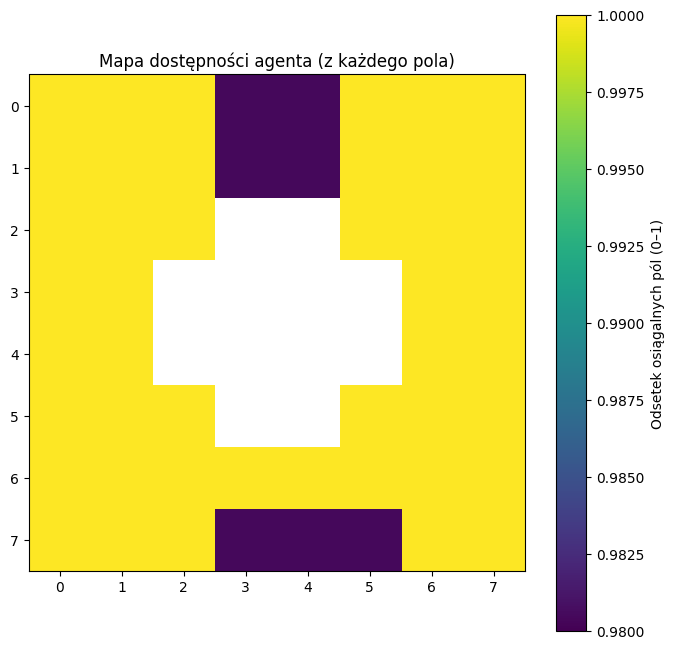

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
# Zastępujemy -1 (przeszkody) wartością np. np.nan, żeby heatmap pominęła
heatmap_data = np.where(reach_map < 0, np.nan, reach_map)

cax = plt.imshow(heatmap_data, cmap="viridis", vmin=0.98, vmax=1)
plt.colorbar(cax, label="Odsetek osiągalnych pól (0–1)")
plt.title("Mapa dostępności agenta (z każdego pola)")
plt.show()

In [28]:
a=env.reset
a=env._get_obs


<bound method WarehouseGridEnv2._get_obs of <__main__.WarehouseGridEnv2 object at 0x0000017A30ED9BD0>>


In [106]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Wczytujemy nasz wytrenowany model

trained_model = q_network
def test_agent(env, model, n_episodes=5):
    """
    Wykonujemy n_episodes epizodów i zapisujemy trace w postaci:
    (obs, action, reward, next_obs) dla każdego kroku.
    """
    all_episode_rewards = []
    all_traces = []  # aby przechować szczegółowe info do ewentualnej wizualizacji

    for episode_i in range(n_episodes):
        obs_5d = env.reset()
        obs_6d = transform_state_grid(obs_5d)  # Funkcja jak w Twoim kodzie

        episode_reward = 0
        episode_trace = []

        terminated = False
        truncated = False

        while not (terminated or truncated):
            # Wybór akcji - tutaj greedy, bo chcemy pokazać, co robi nauczony agent
            q_values = model.predict(obs_6d[np.newaxis, :], verbose=0)
            action = np.argmax(q_values[0])

            # Krok w środowisku
            next_obs_5d, reward, terminated, truncated, info = env.step(action)
            next_obs_6d = transform_state_grid(next_obs_5d)

            episode_reward += reward

            # Zapis do trace
            episode_trace.append({
                'obs': obs_5d,
                'action': action,
                'reward': reward,
                'next_obs': next_obs_5d
            })

            # Przechodzimy do następnego stanu
            obs_5d = next_obs_5d
            obs_6d = next_obs_6d

        all_episode_rewards.append(episode_reward)
        all_traces.append(episode_trace)

    # Podsumowanie wyników
    avg_reward = np.mean(all_episode_rewards)
    print(f"Test: średni reward z {n_episodes} epizodów = {avg_reward:.2f}")

    return all_episode_rewards, all_traces

# Uruchamiamy testy
env = WarehouseGridEnv2(n=8, max_steps=200,grid=my_grid1)

test_rewards, traces = test_agent(env, trained_model, n_episodes=1)

Test: średni reward z 1 epizodów = 1.10


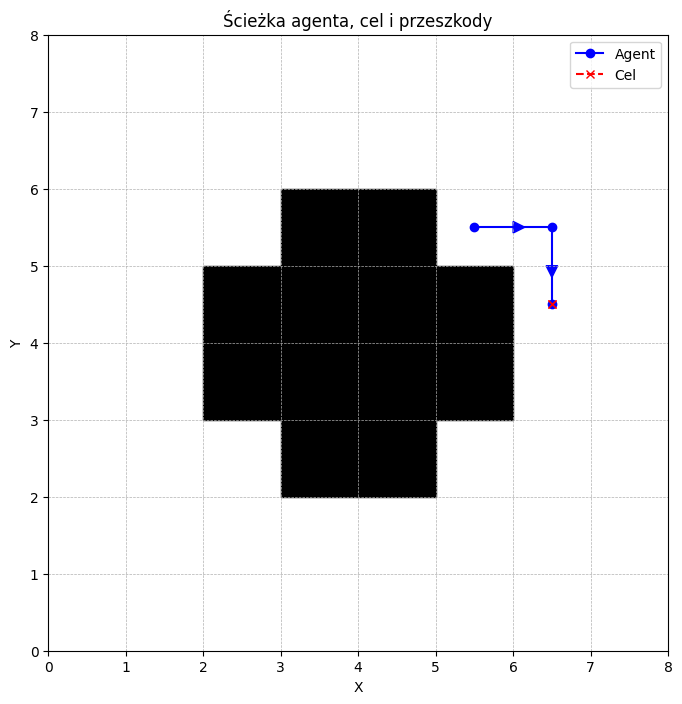

In [111]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_episode(episode_trace, env):
    """
    Wizualizuje pozycje agenta i celu w kolejnych krokach epizodu,
    uwzględniając przeszkody oraz dodając strzałki przy przejściach.
    
    :param episode_trace: lista słowników, gdzie step['obs'] = [agent_x, agent_y, target_x, target_y, ...], 
                          step['next_obs'] zawiera następną obserwację.
    :param env: Obiekt środowiska zawierający grid z przeszkodami
    """
    grid = env.grid  # Pobieramy siatkę ze środowiska
    agent_positions = []
    target_positions = []
    
    for step in episode_trace:
        agent_x, agent_y = step['obs'][0] + 0.5, step['obs'][1] + 0.5
        target_x, target_y = step['obs'][2] + 0.5, step['obs'][3] + 0.5
        
        agent_positions.append((agent_x, agent_y))
        target_positions.append((target_x, target_y))
    
    # Ostatnia znana pozycja agenta
    last_agent_x, last_agent_y = episode_trace[-1]['next_obs'][0] + 0.5, episode_trace[-1]['next_obs'][1] + 0.5
    agent_positions.append((last_agent_x, last_agent_y))
    
    agent_xs = [pos[0] for pos in agent_positions]
    agent_ys = [pos[1] for pos in agent_positions]
    target_xs = [pos[0] for pos in target_positions]
    target_ys = [pos[1] for pos in target_positions]
    
    plt.figure(figsize=(8, 8))
    plt.xlim(0, len(grid[0]))
    plt.ylim(0, len(grid))
    plt.grid(True, linestyle='--', linewidth=0.5)
    
    # Rysujemy przeszkody jako kwadraty o jednostkowej wielkości
    for y in range(len(grid)):
        for x in range(len(grid[0])):
            if grid[y][x] == 1:
                plt.gca().add_patch(plt.Rectangle((x, y), 1, 1, color='black'))
    
    # Rysujemy ścieżkę agenta
    plt.plot(agent_xs, agent_ys, 'bo-', label='Agent')
    
    # Rysujemy ścieżkę celu
    plt.plot(target_xs, target_ys, 'rx--', label='Cel')
    
    # Dodajemy krótsze strzałki pokazujące kierunek ruchu agenta
    for i in range(len(agent_positions) - 1):
        dx = (agent_xs[i+1] - agent_xs[i]) * 0.5  # Skracamy długość strzałek
        dy = (agent_ys[i+1] - agent_ys[i]) * 0.5
        plt.arrow(agent_xs[i], agent_ys[i], dx, dy,
                  head_width=0.15, head_length=0.15, fc='blue', ec='blue')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Ścieżka agenta, cel i przeszkody')
    plt.legend()
    plt.show()



env = WarehouseGridEnv2(n=8, max_steps=200, grid=my_grid1)
visualize_episode(traces[0], env)